# **Waze Project**

# **Build a machine learning model**

**The purpose** of this model is to find factors that drive user churn.

**The goal** is to build a model that predicts whether or not a Waze user is retained or churned.
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations

**Part 2:** Feature engineering

**Part 3:** Building Models

# **Build a machine learning model**

### Ethical considerations 

Lets consider the following questions:

1.   What are we being asked to do?
> _Predict if a customer will churn or be retained._

2.   What are the ethical implications of the model? What are the consequences of your model making errors?
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a Waze user won't churn, but they actually will)?
  > _Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users, or send a survey to better understand user dissatisfaction._
  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a Waze user will churn, but they actually won't)?
  > _Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app._
3.   Do the benefits of such a model outweigh the potential problems?
  > _The proactive measueres taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems._
4.   Would we proceed with the request to build this model? Why or why not?

  >_Yes. There aren't any significant risks for building such a model._


### **Imports and data loading**

In [25]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import os
import pickle

In [2]:
# Importing dataset
df = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspecting the first five rows
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


**Note:**

From our previous phases we know:
- data has  700 missing values in our outcome feature (label).
- data has no duplicates
- churn rate correlates with distance driven per driving day in the last month
- these columns have outliers:
    * `sessions`
    * `drives`
    * `total_sessions`
    * `total_navigations_fav1`
    * `total_navigations_fav2`
    * `driven_km_drives`
    * `duration_minutes_drives`

we will start by removing the ID column since you don't need this information for your analysis.

In [5]:
# Drop `ID` column
df = df.drop('ID', axis=1)

In [6]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

We know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Feature engineering**

we have already prepared much of this data and performed exploratory data analysis (EDA) in previous phases. we know that some features had stronger correlations with churn than others, and we also created some features that may be useful.

So we'll engineer these features and some new features to use for modeling.

#### **`km_per_driving_day`**
Since we know that churn rate correlates with distance driven per driving day in the last month. It might be helpful to engineer a feature that captures this information.

We will create a feature representing the mean number of kilometers driven on each driving day in the last month for each user

In [7]:
# Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Get descriptive stats
df['km_per_driving_day'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.241789e+02
75%      7.608293e+02
max               inf
Name: km_per_driving_day, dtype: float64

Note that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

Lets fix this problem.

In [8]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

we will create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

In [9]:
# Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.449837
std          0.286863
min          0.000000
25%          0.196890
50%          0.424310
75%          0.687251
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

We will Create a new binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [10]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

Lets perform a quick inspection of the new variable.

In [11]:
# Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    11811
1     2488
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

#### **`total_sessions_per_day`**

we will create a new column that represents the mean number of sessions per day _since onboarding_.

In [12]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

As with other features, get descriptive statistics for this new feature.

In [13]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.338207
std          1.319814
min          0.000298
25%          0.050818
50%          0.100457
75%          0.215210
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

we will create a column representing the mean kilometers per hour driven in the last month.

In [14]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14299.000000
mean       190.730963
std        339.926138
min         72.013095
25%         90.649402
50%        122.105845
75%        193.238449
max      23642.920871
Name: km_per_hour, dtype: float64

**Note:**

These numbers are obviously problematic, and it would be worthwhile to seek clarification from Waze regarding how these features are collected to better understand why such unrealistic speeds are observed.

#### **`km_per_drive`**

we will create a column representing the mean number of kilometers per drive made in the last month for each user.

In [15]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.325389e+01
50%      7.490594e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. we will convert the infinite values to zero, then confirm that it worked.

In [16]:
# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Confirm that it worked
df['km_per_drive'].describe()

count    14299.000000
mean       232.269197
std        616.197409
min          0.000000
25%         32.486524
50%         72.947059
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, we ill create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [17]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14299.000000
mean         1.676347
std          9.021250
min          0.000000
25%          0.206064
50%          0.653572
75%          1.643183
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### **Feature encoding**

we will:

For `label` column:

* `retained` -> `0`

* `churned` => `1`

For `device2` column:

* `Android` -> `0`
* `iPhone` -> `1`

In [18]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [19]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Feature selection**

Tree-based models can handle multicollinearity, so we will keep every feature

### **Evaluation metric**

Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, lets examine the class balance of your target variable.

In [20]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the **recall** score.

### **Split the data**

In [21]:
# Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# Isolate y variable
y = df['label2']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

### **Models Building**

#### **Random forest**

In [22]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': ['sqrt', 'log2'],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [23]:
%%time
rf.fit(X_train, y_train)

CPU times: user 7min 56s, sys: 1.04 s, total: 7min 57s
Wall time: 7min 57s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

#### Save random forest model

In [26]:
# Define a path to the folder where you want to save the model
path = os.getcwd() + "/"

In [27]:
def write_pickle(path, model_object, save_name):
    """save_name is a string."""
    with open(path + save_name + '.pickle', 'wb') as f:
        pickle.dump(model_object, f)

In [28]:
def read_pickle(path, saved_model_name):
    """saved_model_name is a string."""
    with open(path + saved_model_name + '.pickle', 'rb') as f:
        model = pickle.load(f)

        return model

In [29]:
# write model to file
write_pickle(path, rf, "rf_model")

In [30]:
# read model from file
rf = read_pickle(path, "rf_model")

Examine the best average score across all the validation folds.

In [32]:
# Examine best score
rf.best_score_

0.1197593921321965

Examine the best combination of hyperparameters.

In [33]:
# Examine best hyperparameter combo
rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [34]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [35]:
results = make_results('RF cv', rf, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.475076,0.119759,0.191189,0.820351


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy

#### **XGBoost**

In [36]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [37]:
%%time
xgb.fit(X_train, y_train)

CPU times: user 5min 52s, sys: 2.07 s, total: 5min 54s
Wall time: 3min


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

#### Save XGB Boost model

In [38]:
# write model to file
write_pickle(path, xgb, "xgb_model")

In [39]:
# read model from file
xgb = read_pickle(path, "xgb_model")

Get the best score from this model.

In [40]:
# Examine best score
xgb.best_score_

0.15870529127646027

And the best parameters.

In [41]:
# Examine best parameters
xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

In [43]:
xgb_cv_results = make_results('XGB cv', xgb, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.475076,0.119759,0.191189,0.820351
0,XGB cv,0.409633,0.158705,0.228662,0.810385


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

**Note:** XGB is our champion model

### **Use champion model to predict on test data**

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [45]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
        Generate a table of test scores.

        Args:
            model_name (string): Your choice: how the model will be named in the output table
            preds: numpy array of test predictions
            y_test_data: numpy array of y_test data

        Returns:
            table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [46]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.475076,0.119759,0.191189,0.820351
0,XGB cv,0.409633,0.158705,0.228662,0.810385
0,XGB test,0.410891,0.163708,0.234133,0.810140


The recall was exactly the same as it was on the cross-validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Confusion matrix**

lets plot a confusion matrix of the champion model's predictions on the test data.

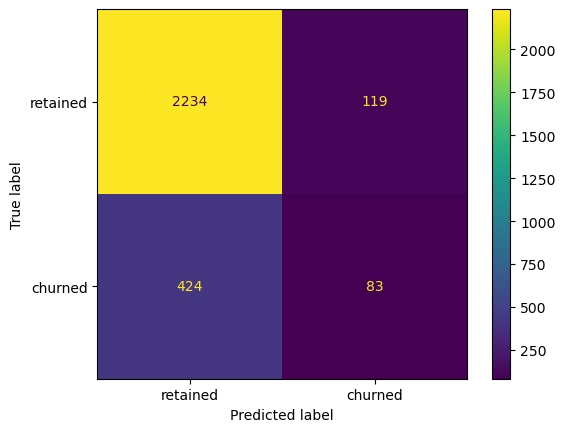

In [60]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

**Note:**

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

#### **Identifing an optimal decision threshold**

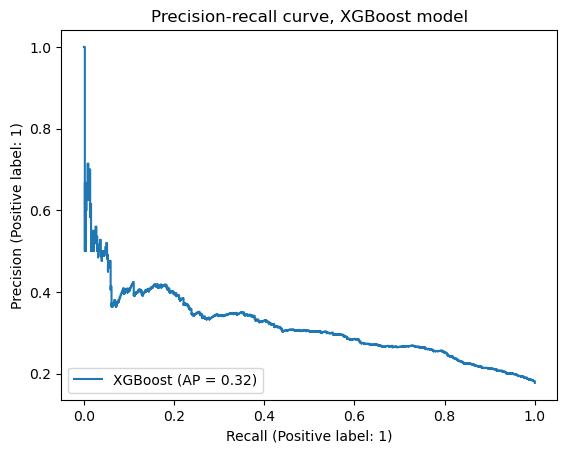

In [48]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

**Note:**

As recall increases, precision decreases. But what if we determined that false positives aren't much of a problem? as the case for our project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, what if instead of using the default 0.5 decision threshold of the model, we used a lower threshold to get better recall?

In [49]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.9351489 , 0.06485112],
       [0.72305644, 0.2769436 ],
       [0.9930792 , 0.00692082],
       ...,
       [0.7924308 , 0.20756917],
       [0.96433   , 0.03566996],
       [0.7665284 , 0.23347156]], dtype=float32)

In [50]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.378947,0.213018,0.272727,0.798601


In [52]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.475076,0.119759,0.191189,0.820351
0,XGB cv,0.409633,0.158705,0.228662,0.810385
0,XGB test,0.410891,0.163708,0.234133,0.810140


**Note:**

Recall and F1 score increased significantly, while precision and accuracy decreased marginally.

In [53]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


Now, lets test the function to find the threshold that results in a recall score closest to 0.5.

In [55]:
# Get the predicted probabilities from the champion model
probabilities = xgb.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.127, 0.5009861932938856)

Setting a threshold of 0.127 will result in a recall of 0.501.

In [57]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.127 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.127', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.127",0.303465,0.500986,0.377976,0.707692


### **Feature importance**

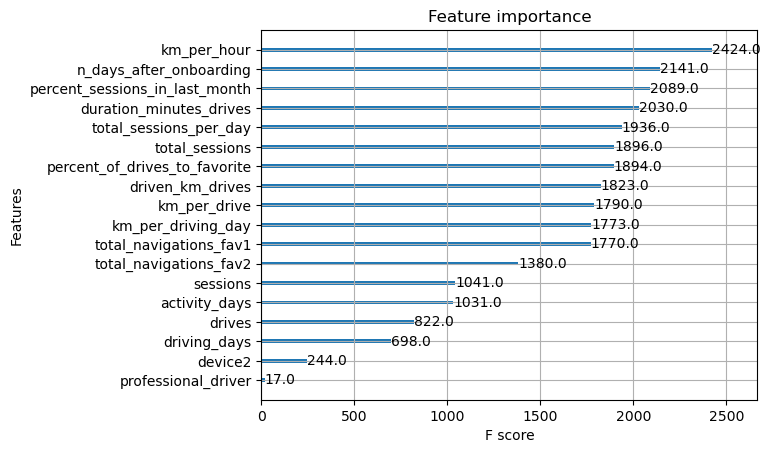

In [59]:
plot_importance(xgb.best_estimator_);

### **Conclusion**


**Questions:**

1. Would we recommend using this model for churn prediction? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._


2. What could we do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

3. What additional features would we like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._


## Summary

Share an executive summary with my team [link](https://github.com/yousefayman2003/Portfolio-Projects/tree/main/Data-Science/Waze/machine_learning/executive_summary.pdf)